In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from sklearn import datasets
from IPython.display import display
import ipywidgets as widgets
import scipy
import math
import cv2

In [2]:
#All rights resevred to n0acar (github username)
def plot_portraits(images, titles, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].real.reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

# Capturing the image
###### (Not related to class content, skip if not interested.)

In [76]:
#Opens the camera
camera = cv2.VideoCapture(0)

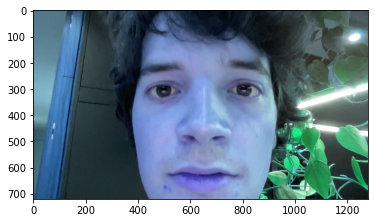

In [77]:
#Taking a picture of you
ret, frame = camera.read()
RBGFace = np.array(frame)
plt.imshow(frame)
plt.show()
camera.release()

In [78]:
#Converting to greyscale:
def rbg2gray(rgb):
    return np.dot(rgb[...,:3], [0.2982, 0.5870, 0.1140])
#*from stackexchange user unutbu

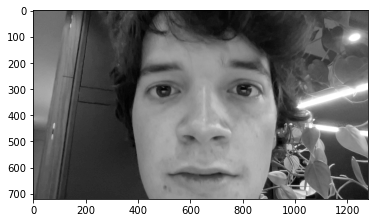

In [79]:
#Converting to grayscale and plotting new image:
gsFace = rbg2gray(RBGFace)
plt.imshow(gsFace, cmap = 'gray')

In [80]:
#Next, we convert this image into a 64x64 pixel array:
height, width = gsFace.shape

#Cropping the sides:
croppedFace = gsFace[0 : height, (width-height)//2 : width - (width-height)//2]
#Note that this assumes width > height. If your camera produces an image with height > width,
#Comment out the last line and use this instead:
# croppedFace = gsFace[(height-width)//2 : height - (height-width)//2, 0:width]

#Scaling it down (taking the average of neighboring pixels):
scaledFace = np.zeros(shape=(64,64))
div = height//64
k, q = 0, 0

for i in range (64):
    for j in range (64):
        scaledFace[i,j] = np.mean(croppedFace[k : k + div, q : q + div])
        q += div
    k += div
    q = 0

#As a last step, we normalize the array to match the dataset we'll use:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

scaledFaceNormalized = (scaledFace - np.min(scaledFace))/np.ptp(scaledFace)

#Note that this approach is very rudimentary, we just crop the sides until the image is square and scale it down.

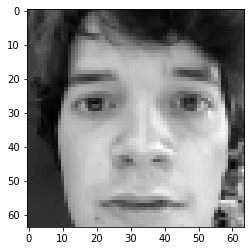

In [81]:
#We now have an appropriate array to work with!
plt.imshow(scaledFaceNormalized, cmap = 'gray')

In [82]:
#saving to computer

np.save('/users/felipemautner/Documents/felipe.npy',scaledFaceNormalized)

# Onto SVD!

In [30]:
#Getting the dataset we'll use to perform SVD:
olivetti = sklearn.datasets.fetch_olivetti_faces()
faces = olivetti['data']

#'faces' is a 400x4096 array, where we have 400 instance of 64x64 images of 
# faces stored as single columns

We'll call the `faces` dataset $F$. We want to perform the following decomposition:

$$F = U \Sigma V^T$$

We can do this with a numpy function.

We know the columns of $U$ are the unit eigenvectors of $FF^T$\
We know the columns of $V$ are the unit eigenvectors of $F^TF$
We know $\Sigma$ is a 'pseudo-diagonal' matrix of the singular values of $FF^T$ and $F^TF$\
We also know we need to sort the singular values of $\Sigma$ accordingly with the eigenvectors in $U$ and $V$.

With this in mind, we can find these values:

### SVD with numpy:

In [31]:
Unp, s, VTnp = np.linalg.svd(faces, compute_uv=True)
Snp = np.zeros(shape=(400,4096))
for i in range(400):
    Snp[i,i] = s[i]

#The numpy function returns a list of the singular values, so we need to put them into S.

In [32]:
#Sanity check:

SVDTest = Unp@Snp@VTnp

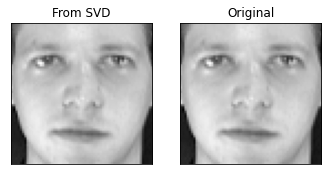

In [33]:
plot_portraits([SVDTest[0], faces[0]], ['From SVD', 'Original'], 64, 64, 1, 2)

#### What's happening?


Recall that SVD can be expressed as a sum of rank 1 matrices:

$A = \sigma_1 u_1 v_1^T + \sigma_2 u_2 v_2^T + \cdots + \sigma_r u_r v_r^T+ \cdots + \sigma_n u_n v_n^T$

As such, we can cut this sum at any one of the terms, which is exactly what the demonstration above does. To have a bit more of a conceptual understanding of what is going on, we can look at what the actual faces look like when we stop the sum at a given term:

In [34]:
#Tha rank of 'faces' is 400. Let's look at what happens as we add more terms/ 
# get closer to the full rank:
SVDfaces = []


for i in range (0, 400, 50):
    SVDfaces.append((Unp[:, 0:i]@Snp[0:i, 0:i]@VTnp[0:i, :])[0])

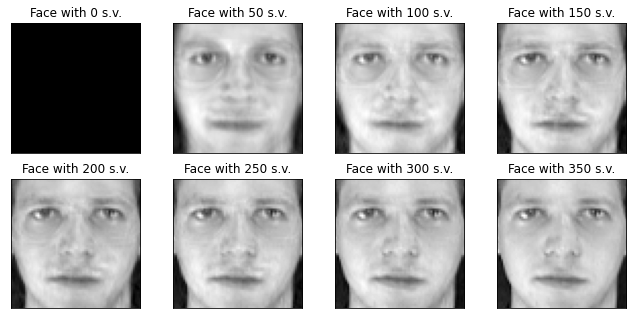

In [35]:
titles = ["Face with %d s.v." %i for i in range(0, 400, 50)]
plot_portraits(SVDfaces, titles, 64, 64, 2, 4)

As you can see, the image already looks somewhat recognizable with only 50 singular values and almost identical to the original image with 200. This is a 50% reduction in file size and we retain almost all information! If you're wondering how this translates into the real world, with some simple statistics we can turn SVD into an even more useful tool...

## Data Science and Rudimentary facial reconstruction and recognition (PCA)

In [36]:
##Recognize my own face
##Take face from dataset, add noise and recognize it

We will now slightly adjust the original demonstration and our goal will be altered as well. Our objective is now to use SVD for dimensionality reduction on a dataset and to perform a very rudimentary application of facial reconstruction and recognition.

Most (if not all) of the work ahead comes from Matthew Turk's and Alex Pentland's *'Eigenfaces for Recognition'*, a paper I highly recommend you read!!

### The idea:

By deconstructing our dataset of faces into its intrinsic components, which we'll later call 'eigenfaces', we can express each face as a collection of 'weights', or, coefficients of a linear transformation we get from projecting said image to a lower dimensional 'facespace'.

This in turn allows us to project new images to this space, and try to find the closest image to it present in the dataset, making a prediciton of what face we have.

### In practice:

The first difference from the SVD demo is that this time we will view the dataset as a $f\times d$ matrix instead of a $d \times f$ one, where $f$ stands for *features* (pixels) and $d$ for *datapoints* or *instances*. We do this to follow standard data science practices:

In [37]:
olivetti = sklearn.datasets.fetch_olivetti_faces()
faces = olivetti['data']

Next, we need to normalize the dataset, meaning, we compute the 'average' instance/ face and subtract it from the matrix (columnwise). The reason we do this is so we can apply some statistical knowledge and tools later.

In [38]:
avgFace = np.average(faces, axis=0)

Let's take a look at what the 'average' face looks like in this dataset!

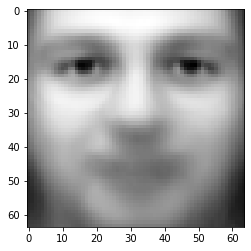

In [39]:
plt.imshow(avgFace.reshape(64,64), cmap='gray')

We now subtract it from all faces in the dataset:

In [40]:
normFaces = faces - avgFace

We can now very simply compute the covariance matrix of the dataset. Let's call this matrix $C$, where $C_{ij} = cov(\text{faces[i]}, \text{faces[j]}) = \frac{1}{4096} \sum_{k=1}^{4096}\text{(faces[i,k]- average faces[i])(faces[j,k]- average faces[j])}$. Note however that since we normalized the dataset, we can simply express $C$ as $F^TF$. 

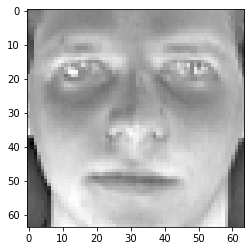

In [41]:
plt.imshow(normFaces[0].reshape(64,64), cmap='gray')

We now perform SVD on the covariance matrix, $F^TF$:

In [42]:
#Performing PCA:

S = normFaces.T@normFaces
eigvals, eigvecs = np.linalg.eig(S)
order = np.argsort(eigvals)[::-1]
sorted_eigvals = eigvals[order]
sorted_eigvecs = eigvecs[:, order]

Recall that the principal components are the $v_i$'s. Let's look at what they actually look like:

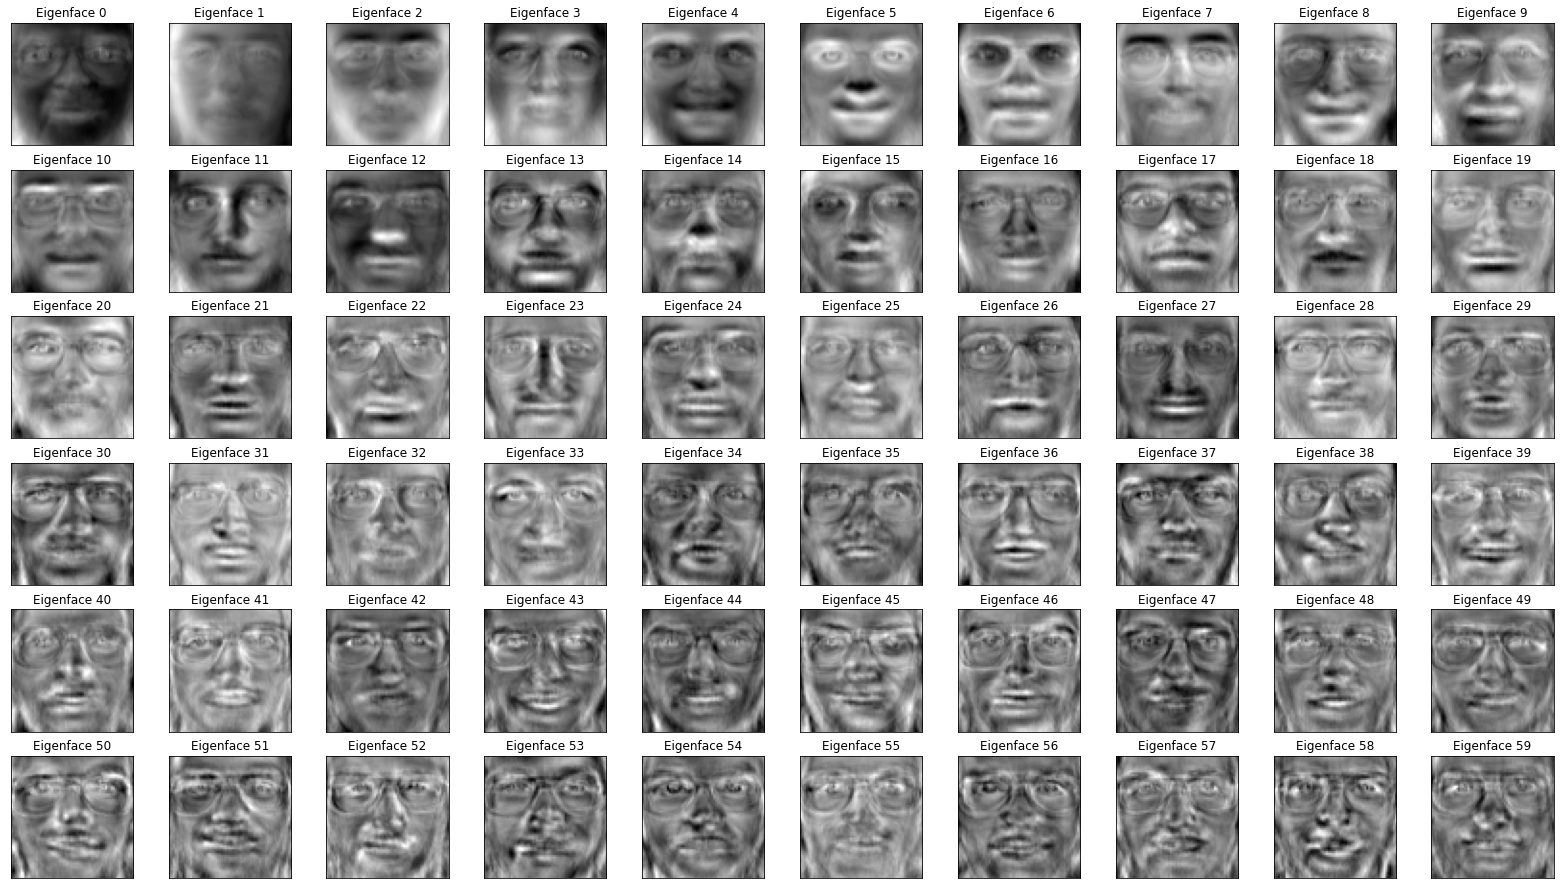

In [43]:
eigtitles = ["Eigenface %d" %i for i in range(4096)]
plot_portraits(sorted_eigvecs.real.T, eigtitles, 64,64,6,10)

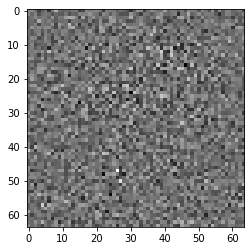

In [44]:
plt.imshow(sorted_eigvecs.real.T[2000].reshape(64,64), cmap='gray')

This gives a very interesting observation as to what is going on when we do PCA for a dataset. We are expressing the instances of the original dataset as linear combinations of the $v_i$'s, in our case, the eigenfaces:

$$\text{face} = f = (f^T v_1) v_1 +\cdots + (f^T v_n) v_n$$

That means that we can find out how an image in the `faces` dataset breaks down into eigenfaces. We can do this by projecting an image into the subspace spanned by the eigenfaces, to get the coefficients in our linear combination. We do so by combining the eigenfaces into a single matrix, $E$, who's rows are the eigenfaces. Then, 

$$Ef = (f^T v_1,\ldots, f^T v_n)$$

is a vector of the coefficients used in the linear combination.

In [45]:
E = sorted_eigvecs.T

Sanity check:

In [46]:
coeffs0 = E@faces[0]

In [47]:
testReconstruction = np.zeros(shape=(4096))

for i in range(4096):
    testReconstruction += coeffs0[i]*E[i]

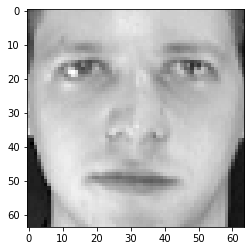

In [48]:
plt.imshow(testReconstruction.reshape(64,64), cmap='gray')

We have seen before that we can cut this sum at any point, and indeed,

In [49]:
testReconstruction_quarter = np.zeros(shape=(4096))

for i in range(200):
    testReconstruction_quarter += coeffs0[i]*E[i]

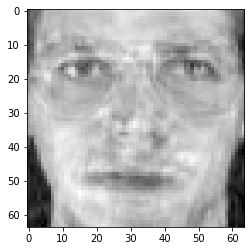

In [50]:
plt.imshow(testReconstruction_quarter.reshape(64,64), cmap='gray')

Now, nothing is stopping us from using a new, completely different image! This is where we can really begin to have some fun with image reconstruction. Let's project our own picture onto the 'eigenfaces' and see what we get!

In [83]:
myCoeffs = E@scaledFaceNormalized.reshape(4096)

In [84]:
myCoeffs

array([-3.15049294e+01, -3.31773371e-01,  2.08407654e+00, ...,
       -9.00977106e-03,  2.90370553e-02, -2.81230846e-03])

So, by adding approximately -31 of the first eigenface, 4.15 of the second, 3.97 of the third and so on, we get the best fit approximation to out image:

In [89]:
myReconstruction = np.zeros(4096)

for i in range(2000):
    myReconstruction += myCoeffs[i]*E[i]

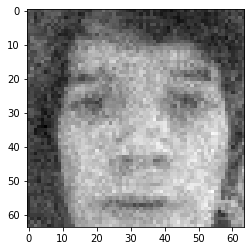

In [90]:
plt.imshow(myReconstruction.reshape(64,64), cmap='gray')

We can perform rudimentary detection by determining the vector in the dataset that minimizes the magnitude of the difference of said vector and the projected image:

$$||v-\text{projected}f||$$

We can do this by just looking at the coefficients and making our lives easier. We first need to colloect the coefficients on our dataset: